In [1]:
#!/usr/bin/env python3
"""
Bayesian Neural Network for Chemical Data:
A Detailed Demonstration of Bayesian Inference and Uncertainty Quantification

In this script we:
  - Generate synthetic chemical data with two features.
  - Define a Bayesian neural network model with one hidden layer.
  - Specify priors for the network parameters and the noise level.
  - Compute the likelihood of the data given the model using a Gaussian noise assumption.
  - Implement a Metropolis–Hastings MCMC sampler to sample from the posterior.
  - Print diagnostic messages during sampling and produce multiple plots:
      • Scatter plot of the synthetic data.
      • Trace plots and histograms for selected parameters.
      • Posterior predictive plots showing uncertainty.


"""


'\nBayesian Neural Network for Chemical Data:\nA Detailed Demonstration of Bayesian Inference and Uncertainty Quantification\n\nIn this script we:\n  - Generate synthetic chemical data with two features.\n  - Define a Bayesian neural network model with one hidden layer.\n  - Specify priors for the network parameters and the noise level.\n  - Compute the likelihood of the data given the model using a Gaussian noise assumption.\n  - Implement a Metropolis–Hastings MCMC sampler to sample from the posterior.\n  - Print diagnostic messages during sampling and produce multiple plots:\n      • Scatter plot of the synthetic data.\n      • Trace plots and histograms for selected parameters.\n      • Posterior predictive plots showing uncertainty.\n\n\n'

In [2]:
################################################################################
# Cell 1: Imports and Global Setup
################################################################################
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import time

# Set a global random seed for reproducibility.
np.random.seed(42)

In [3]:
################################################################################
# Cell 2: Synthetic Chemical Data Generation
################################################################################
def generate_chemical_data(n_samples=100):
    """
    Generate synthetic chemical data with two features.

    We assume two input features:
      - x1: Could represent molecular weight, uniformly distributed between 50 and 150.
      - x2: Could represent an electronic property (e.g., electronegativity), uniformly between 0 and 1.

    The target property y is modeled by a nonlinear function:
        y = sin((x1-50)/50 * pi) + 0.5 * cos(x2 * 2*pi) + noise
    where noise is drawn from a normal distribution (std=0.2).

    Returns:
      X     : numpy array of shape (n_samples, 2) containing the features.
      y     : observed target values with noise.
      y_true: underlying true function values without noise.
    """
    print("Generating synthetic chemical data...")
    x1 = np.random.uniform(50, 150, n_samples)
    x2 = np.random.uniform(0, 1, n_samples)
    X = np.column_stack((x1, x2))
    # True underlying function (nonlinear relationship)
    y_true = np.sin((x1 - 50) / 50 * np.pi) + 0.5 * np.cos(x2 * 2 * np.pi)
    noise = np.random.normal(0, 0.2, n_samples)
    y = y_true + noise
    print("Data generation complete. Sample of first 5 data points:")
    print("X[0:5] =\n", X[:5])
    print("y[0:5] =", y[:5])
    return X, y, y_true

In [4]:
################################################################################
# Cell 3: Bayesian Neural Network Model Definitions
################################################################################
def unpack_params(theta, H):
    """
    Unpack the flattened parameter vector theta into network parameters.

    We assume a one-hidden-layer neural network with:
      - Input dimension = 2
      - Hidden layer size = H
      - Output dimension = 1

    The parameter vector theta has length: 4*H + 2, where:
      • W1: weights for input to hidden (shape: H x 2)    -> 2*H parameters
      • b1: biases for hidden layer (shape: H)             -> H parameters
      • W2: weights for hidden to output (shape: H)         -> H parameters
      • b2: bias for output (scalar)                        -> 1 parameter
      • sigma: noise standard deviation                    -> 1 parameter

    Returns a dictionary with keys 'W1', 'b1', 'W2', 'b2', and 'sigma'.
    """
    input_dim = 2
    idx = 0
    W1 = theta[idx: idx + H * input_dim].reshape(H, input_dim)
    idx += H * input_dim
    b1 = theta[idx: idx + H]
    idx += H
    W2 = theta[idx: idx + H]
    idx += H
    b2 = theta[idx]
    idx += 1
    sigma = theta[idx]
    return {'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2, 'sigma': sigma}

def nn_predict(theta, X, H=5):
    """
    Compute neural network predictions for input X given parameters theta.

    The network applies a tanh activation function in the hidden layer:
        hidden = tanh(X * W1^T + b1)
        y_pred = hidden dot W2 + b2

    Parameters:
      theta: Flattened parameter vector.
      X    : Input data of shape (n_samples, 2).
      H    : Number of hidden neurons.

    Returns:
      y_pred: Predicted outputs (1D numpy array).
    """
    params = unpack_params(theta, H)
    W1, b1, W2, b2 = params['W1'], params['b1'], params['W2'], params['b2']
    # Compute hidden layer activations
    hidden = np.tanh(np.dot(X, W1.T) + b1)
    # Compute output predictions
    y_pred = np.dot(hidden, W2) + b2
    return y_pred

def log_prior(theta, H=5, prior_std=1.0):
    """
    Compute the log prior probability of the parameters.

    We assume:
      - Each weight and bias (all parameters except sigma) ~ N(0, prior_std).
      - sigma (noise std) ~ Half-Normal(prior_std): i.e., N(0, prior_std) with sigma > 0.

    Returns:
      Log prior probability (float). If sigma <= 0, returns -infinity.
    """
    sigma = theta[-1]
    if sigma <= 0:
        return -np.inf
    # Log pdf for weights and biases
    lp = np.sum(norm.logpdf(theta[:-1], loc=0, scale=prior_std))
    # For sigma, use half-normal distribution (double the probability mass for sigma > 0)
    lp_sigma = norm.logpdf(sigma, loc=0, scale=prior_std) + np.log(2)
    return lp + lp_sigma

def log_likelihood(theta, X, y, H=5):
    """
    Compute the log likelihood of the data given the neural network parameters.

    The likelihood is defined as:
      y ~ N(nn_predict(theta, X), sigma)
    where sigma is the noise standard deviation (last element in theta).

    Returns:
      The summed log likelihood over all data points.
    """
    params = unpack_params(theta, H)
    sigma = params['sigma']
    if sigma <= 0:
        return -np.inf
    y_pred = nn_predict(theta, X, H)
    ll = np.sum(norm.logpdf(y, loc=y_pred, scale=sigma))
    return ll

def log_posterior(theta, X, y, H=5, prior_std=1.0):
    """
    Compute the unnormalized log posterior for the neural network parameters.

    This is the sum of the log prior and the log likelihood.
    """
    lp = log_prior(theta, H, prior_std)
    if not np.isfinite(lp):
        return -np.inf
    ll = log_likelihood(theta, X, y, H)
    return lp + ll

In [5]:
################################################################################
# Cell 4: Metropolis–Hastings MCMC Sampler for the Bayesian Neural Network
################################################################################
def metropolis_hastings(theta_init, iterations, proposal_std, X, y, H=5, prior_std=1.0):
    """
    Run the Metropolis–Hastings MCMC algorithm to sample from the posterior.

    Parameters:
      theta_init   : Initial parameter vector (numpy array of length 4*H+2).
      iterations   : Total number of MCMC iterations.
      proposal_std : Standard deviation for the Gaussian proposal (can be scalar or same shape as theta).
      X, y         : Data (features and target values).
      H            : Number of hidden neurons.
      prior_std    : Prior standard deviation for all parameters.

    Returns:
      samples       : Array of shape (iterations, len(theta)) containing all sampled parameter vectors.
      acceptance_rate: Overall acceptance rate of the proposals.
    """
    theta_current = theta_init.copy()
    log_post_current = log_posterior(theta_current, X, y, H, prior_std)
    samples = []
    accepted = 0

    print("Starting MCMC sampling for Bayesian Neural Network...")
    start_time = time.time()
    for i in range(iterations):
        # Propose new parameter vector via Gaussian random walk
        theta_proposal = theta_current + np.random.normal(0, proposal_std, size=theta_current.shape)
        log_post_proposal = log_posterior(theta_proposal, X, y, H, prior_std)
        # Calculate acceptance probability (in log space)
        log_accept_ratio = log_post_proposal - log_post_current
        if np.log(np.random.rand()) < log_accept_ratio:
            theta_current = theta_proposal
            log_post_current = log_post_proposal
            accepted += 1
        samples.append(theta_current.copy())
        # Print progress every 500 iterations
        if (i + 1) % 500 == 0:
            elapsed = time.time() - start_time
            print(f"Iteration {i+1}/{iterations} complete. Acceptance rate so far: {accepted/(i+1):.3f}. Elapsed time: {elapsed:.2f} s.")
    samples = np.array(samples)
    overall_accept_rate = accepted / iterations
    print(f"MCMC sampling finished. Overall acceptance rate: {overall_accept_rate:.3f}")
    return samples, overall_accept_rate

In [6]:
################################################################################
# Cell 5: Plotting Functions for Diagnostics and Posterior Analysis
################################################################################
def plot_data(X, y, y_true=None):
    """
    Plot the synthetic chemical data.

    We plot x1 (e.g., molecular weight) on the x-axis and the target y on the y-axis.
    The color of each point indicates the value of x2.
    If provided, the true underlying function values (y_true) are also plotted.
    """
    plt.figure(figsize=(8, 6))
    sc = plt.scatter(X[:, 0], y, c=X[:, 1], cmap='viridis', label='Observed data')
    if y_true is not None:
        plt.scatter(X[:, 0], y_true, facecolors='none', edgecolors='red', label='True function')
    plt.colorbar(sc, label='x2 value')
    plt.xlabel('Feature x1 (e.g., molecular weight)')
    plt.ylabel('Target Chemical Property')
    plt.title('Synthetic Chemical Data')
    plt.legend()
    plt.show()

def plot_trace(samples, param_index, param_name):
    """
    Plot the trace (value over iterations) for a selected parameter.

    Parameters:
      samples    : MCMC samples (numpy array).
      param_index: The index of the parameter in the flattened theta.
      param_name : Descriptive name for labeling.
    """
    plt.figure(figsize=(8, 4))
    plt.plot(samples[:, param_index], color='blue')
    plt.xlabel('Iteration')
    plt.ylabel(param_name)
    plt.title(f"Trace Plot for {param_name}")
    plt.show()

def plot_histogram(samples, param_index, param_name, bins=30):
    """
    Plot a histogram of the posterior samples for a selected parameter.
    """
    plt.figure(figsize=(8, 4))
    plt.hist(samples[:, param_index], bins=bins, color='green', edgecolor='black', alpha=0.7)
    plt.xlabel(param_name)
    plt.ylabel('Frequency')
    plt.title(f"Posterior Distribution of {param_name}")
    plt.show()

def plot_predictions(X, y, theta_samples, H=5):
    """
    Plot the data along with predictions from several neural network posterior samples.

    For visualization, we fix x2 at its median value and generate predictions over a grid
    in x1. Each sampled network gives a different regression curve.
    """
    x1_grid = np.linspace(np.min(X[:, 0]), np.max(X[:, 0]), 100)
    fixed_x2 = np.median(X[:, 1])
    X_grid = np.column_stack((x1_grid, np.full_like(x1_grid, fixed_x2)))

    plt.figure(figsize=(10, 6))
    plt.scatter(X[:, 0], y, color='black', label='Observed data', alpha=0.6)

    # Plot predictions for a random subset of samples for clarity
    idx = np.random.choice(len(theta_samples), size=50, replace=False)
    for i in idx:
        theta = theta_samples[i]
        y_pred = nn_predict(theta, X_grid, H)
        plt.plot(x1_grid, y_pred, color='blue', alpha=0.1)
    plt.xlabel('Feature x1 (e.g., molecular weight)')
    plt.ylabel('Predicted Chemical Property')
    plt.title('Posterior Predictive Samples (x2 fixed at median)')
    plt.legend()
    plt.show()

def plot_posterior_predictive_uncertainty(theta_samples, X, H=5):
    """
    Plot the posterior predictive uncertainty on the training data.

    For each data point, we compute the distribution of predictions from the posterior samples
    and plot the mean along with 95% credible intervals.
    """
    n_samples = theta_samples.shape[0]
    predictions = np.zeros((n_samples, len(X)))
    for i in range(n_samples):
        predictions[i, :] = nn_predict(theta_samples[i], X, H)
    pred_mean = np.mean(predictions, axis=0)
    lower = np.percentile(predictions, 2.5, axis=0)
    upper = np.percentile(predictions, 97.5, axis=0)

    plt.figure(figsize=(10, 6))
    plt.errorbar(np.arange(len(X)), pred_mean, yerr=[pred_mean - lower, upper - pred_mean],
                 fmt='o', ecolor='red', capsize=3, label='Mean prediction with 95% CI')
    plt.xlabel('Data index')
    plt.ylabel('Predicted Chemical Property')
    plt.title('Posterior Predictive Uncertainty on Training Data')
    plt.legend()
    plt.show()

Bayesian Neural Network for Chemical Data Demo

Cell 6.1: Generating synthetic chemical data...
Generating synthetic chemical data...
Data generation complete. Sample of first 5 data points:
X[0:5] =
 [[8.74540119e+01 3.14291857e-02]
 [1.45071431e+02 6.36410411e-01]
 [1.23199394e+02 3.14355981e-01]
 [1.09865848e+02 5.08570691e-01]
 [6.56018640e+01 9.07566474e-01]]
y[0:5] = [ 1.06342459 -0.585614   -1.131708   -1.22309072  1.62183432]


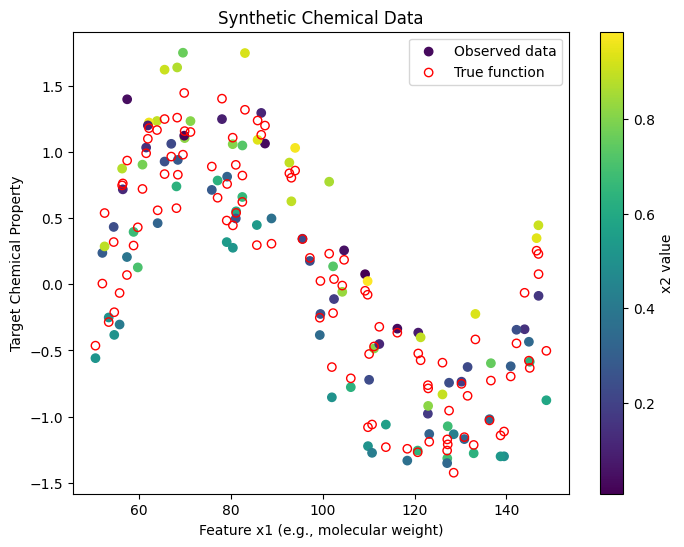


Cell 6.2: Setting up the Bayesian Neural Network model...
Number of hidden neurons (H): 5
Total number of parameters: 22
Initial parameter vector (first 10 values): [ 0.21221562  0.10324653 -0.151937   -0.04842341  0.12669111 -0.07076695
  0.04438194  0.07746341 -0.09269305 -0.00595254]
Initial sigma value: 1.0

Cell 6.3: Running Metropolis–Hastings MCMC sampling...
Starting MCMC sampling for Bayesian Neural Network...
Iteration 500/5000 complete. Acceptance rate so far: 0.202. Elapsed time: 1.08 s.
Iteration 1000/5000 complete. Acceptance rate so far: 0.116. Elapsed time: 2.67 s.
Iteration 1500/5000 complete. Acceptance rate so far: 0.083. Elapsed time: 3.75 s.
Iteration 2000/5000 complete. Acceptance rate so far: 0.064. Elapsed time: 5.17 s.
Iteration 2500/5000 complete. Acceptance rate so far: 0.054. Elapsed time: 6.49 s.
Iteration 3000/5000 complete. Acceptance rate so far: 0.047. Elapsed time: 7.61 s.
Iteration 3500/5000 complete. Acceptance rate so far: 0.042. Elapsed time: 8.42

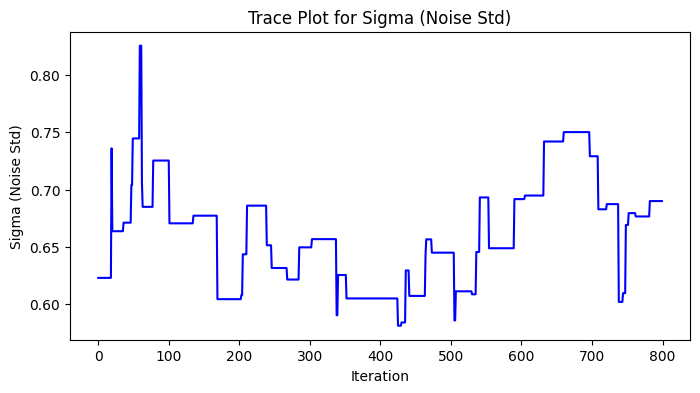

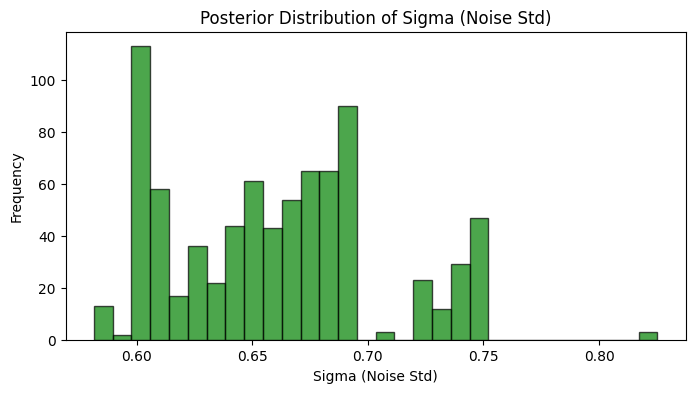

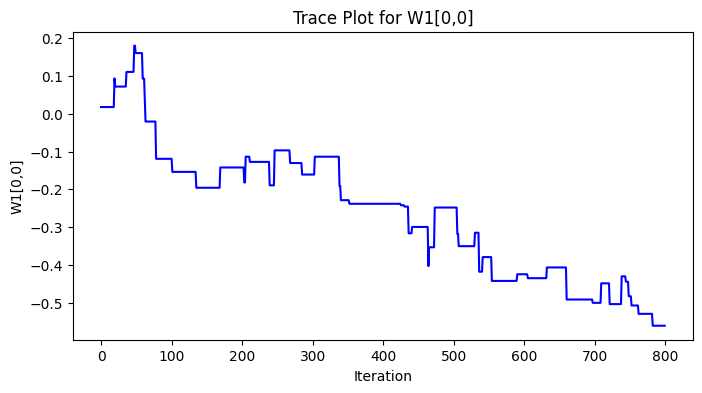

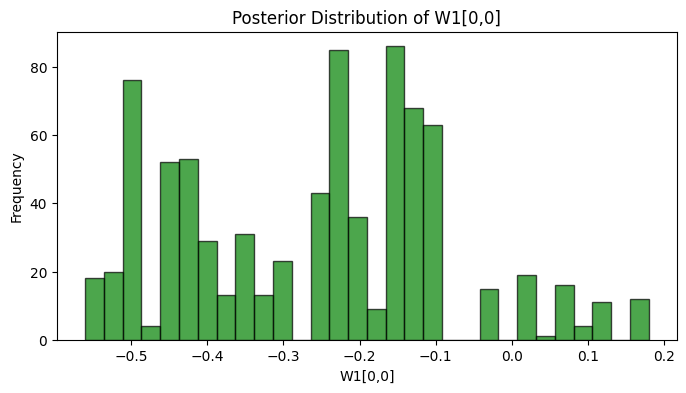


Cell 6.6: Generating posterior predictive plots...


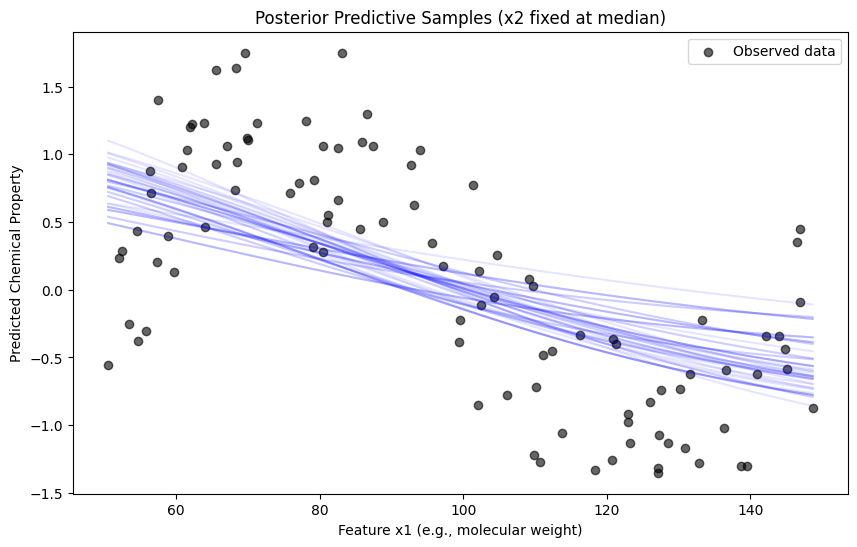

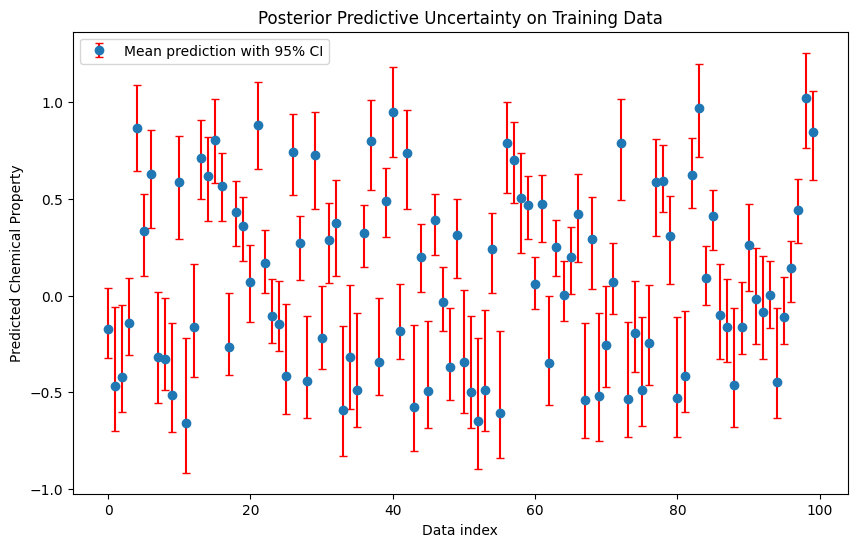


Cell 6.7: Summary of posterior estimates for selected parameters:
Sigma (Noise Std): Mean = 0.661, Std = 0.045
W1[0,0]: Mean = -0.260, Std = 0.174

Bayesian Neural Network analysis complete.


In [7]:
################################################################################
# Cell 6: Main Function – Running the Bayesian Neural Network Analysis
################################################################################
def main():
    """
    Main function to run the Bayesian neural network analysis on chemical data.

    The workflow includes:
      1. Data generation and plotting.
      2. Model and parameter initialization.
      3. Running the Metropolis–Hastings MCMC sampler.
      4. Processing (burn-in and thinning) of MCMC samples.
      5. Diagnostic plots (trace and histograms).
      6. Posterior predictive plots and summary statistics.
    """
    print("=============================================")
    print("Bayesian Neural Network for Chemical Data Demo")
    print("=============================================")

    # --- Cell 6.1: Data Generation ---
    print("\nCell 6.1: Generating synthetic chemical data...")
    X, y, y_true = generate_chemical_data(n_samples=100)
    plot_data(X, y, y_true)

    # --- Cell 6.2: Model Setup ---
    H = 5  # number of hidden neurons
    num_params = 4 * H + 2  # total parameters: W1 (H*2) + b1 (H) + W2 (H) + b2 (1) + sigma (1)
    print("\nCell 6.2: Setting up the Bayesian Neural Network model...")
    print(f"Number of hidden neurons (H): {H}")
    print(f"Total number of parameters: {num_params}")

    # Initialize parameters with small random values and set sigma to 1.0
    theta_init = np.random.normal(0, 0.1, size=num_params)
    theta_init[-1] = 1.0  # sigma
    print("Initial parameter vector (first 10 values):", theta_init[:10])
    print("Initial sigma value:", theta_init[-1])

    # --- Cell 6.3: Run MCMC Sampling ---
    iterations = 5000  # total MCMC iterations (use fewer for demonstration)
    proposal_std = 0.05  # proposal standard deviation
    print("\nCell 6.3: Running Metropolis–Hastings MCMC sampling...")
    samples, acc_rate = metropolis_hastings(theta_init, iterations, proposal_std, X, y, H, prior_std=1.0)
    print("MCMC sampling completed.")
    print("Overall acceptance rate:", acc_rate)

    # --- Cell 6.4: Process MCMC Samples (Burn-in and Thinning) ---
    burn_in = int(0.2 * iterations)
    thinned_samples = samples[burn_in::5]  # thin by taking every 5th sample
    print(f"\nCell 6.4: Processed samples after discarding burn-in (first {burn_in} iterations) and thinning.")
    print("Number of samples retained:", thinned_samples.shape[0])

    # --- Cell 6.5: Diagnostic Plots ---
    print("\nCell 6.5: Generating diagnostic plots...")
    # Example: trace and histogram for sigma (last parameter)
    plot_trace(thinned_samples, -1, "Sigma (Noise Std)")
    plot_histogram(thinned_samples, -1, "Sigma (Noise Std)")
    # Also examine one weight from W1 (e.g., first element)
    plot_trace(thinned_samples, 0, "W1[0,0]")
    plot_histogram(thinned_samples, 0, "W1[0,0]")

    # --- Cell 6.6: Posterior Predictive Plots ---
    print("\nCell 6.6: Generating posterior predictive plots...")
    plot_predictions(X, y, thinned_samples, H)
    plot_posterior_predictive_uncertainty(thinned_samples, X, H)

    # --- Cell 6.7: Summary Statistics ---
    print("\nCell 6.7: Summary of posterior estimates for selected parameters:")
    sigma_samples = thinned_samples[:, -1]
    W1_00_samples = thinned_samples[:, 0]
    print(f"Sigma (Noise Std): Mean = {np.mean(sigma_samples):.3f}, Std = {np.std(sigma_samples):.3f}")
    print(f"W1[0,0]: Mean = {np.mean(W1_00_samples):.3f}, Std = {np.std(W1_00_samples):.3f}")

    print("\nBayesian Neural Network analysis complete.")

# Execute the main function when the script is run
if __name__ == "__main__":
    main()

In [8]:

################################################################################
# END OF SCRIPT
################################################################################

"""
NOTES:
------
This script demonstrates a Bayesian neural network for chemical data by:
  - Creating synthetic data with two features and a nonlinear target.
  - Implementing a simple feedforward network (with one hidden layer and tanh activation).
  - Defining priors for all parameters and a likelihood function based on a Gaussian noise model.
  - Sampling from the posterior using a custom Metropolis–Hastings MCMC sampler.
  - Printing detailed progress messages and producing multiple diagnostic plots.

The code is structured into “cells” (sections) for clarity. Additional printing and plotting
have been included to provide insight at every step of the analysis. This modular design allows
for easy extension and further experimentation with Bayesian neural network models in chemical data analysis.
"""


'\nNOTES:\n------\nThis script demonstrates a Bayesian neural network for chemical data by:\n  - Creating synthetic data with two features and a nonlinear target.\n  - Implementing a simple feedforward network (with one hidden layer and tanh activation).\n  - Defining priors for all parameters and a likelihood function based on a Gaussian noise model.\n  - Sampling from the posterior using a custom Metropolis–Hastings MCMC sampler.\n  - Printing detailed progress messages and producing multiple diagnostic plots.\n  \nThe code is structured into “cells” (sections) for clarity. Additional printing and plotting\nhave been included to provide insight at every step of the analysis. This modular design allows\nfor easy extension and further experimentation with Bayesian neural network models in chemical data analysis.\n'